In [11]:
import sys, os

from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power_indep
sys.path.append(os.path.realpath('..'))

In [12]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import pairwise_distances

from scipy.stats.distributions import chi2
from hyppo.independence.base import IndependenceTest
from hyppo.independence.dcorr import _dcorr
from hyppo.independence._utils import sim_matrix


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}


class KMERF(IndependenceTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be one of the following ")
        IndependenceTest.__init__(self)

    def statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        rf_y = y
        if y.shape[1] == 1:
            rf_y = y.ravel()
        self.clf.fit(x, rf_y)
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        if x.shape[1] == y.shape[1]:
            disty = np.sqrt(1 - sim_matrix(self.clf, y))
        else:
            disty = pairwise_distances(
                y, metric="euclidean"
            )
        stat = _dcorr(distx, disty, bias=False, is_fast=False)

        return stat
    
    def test(self, x, y):
        n = x.shape[0]
        stat = self.statistic(x, y)
        statx = self.statistic(x, x)
        staty = self.statistic(y, y)
        pvalue = chi2.sf(stat ** 2 / np.sqrt(statx ** 2 * staty ** 2) * n + 1, 1)
        return stat, pvalue

In [13]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)

REPS = 1
SAMP_SIZES = list(range(0, 2001, 400))
SAMP_SIZES[0] = 5

In [14]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(power_indep)(KMERF, sim="causal", n=i, p=3, noise=True, reps=REPS) for i in SAMP_SIZES]
)
est_power_signal, est_power_null = map(np.float64, zip(*outputs))

np.savetxt(
    "../kmerf/indep_causal/power_signal.csv",
    est_power_signal,
    delimiter=",",
)
np.savetxt(
    "../kmerf/indep_causal/power_null.csv",
    est_power_null,
    delimiter=",",
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  1.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  4.9min finished


In [9]:
def plot_power():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    ax.set_title(
        "Multivariate Independence Testing\n(Increasing Sample Size)"
    )
    curve_labels = {
        "null" : "False Positive Probability",
        "signal" : "True Positive Probability"
    }
    
    for curve, label in curve_labels.items():
        power = np.genfromtxt(
            "../kmerf/indep_causal/power_{}.csv".format(curve),
            delimiter=",",
        )
        
        ax.plot(SAMP_SIZES, power, lw=4, label=label)
    
    ax.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 1])
    ax.set_xlabel("Sample Sizes")
    ax.set_ylabel("Statistical Power")

    leg = plt.legend(
        bbox_to_anchor=(0.5, -0.01),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(curve_labels.keys()),
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig(
        "../kmerf/figs/indep_power_causal.pdf", transparent=True, bbox_inches="tight"
    )

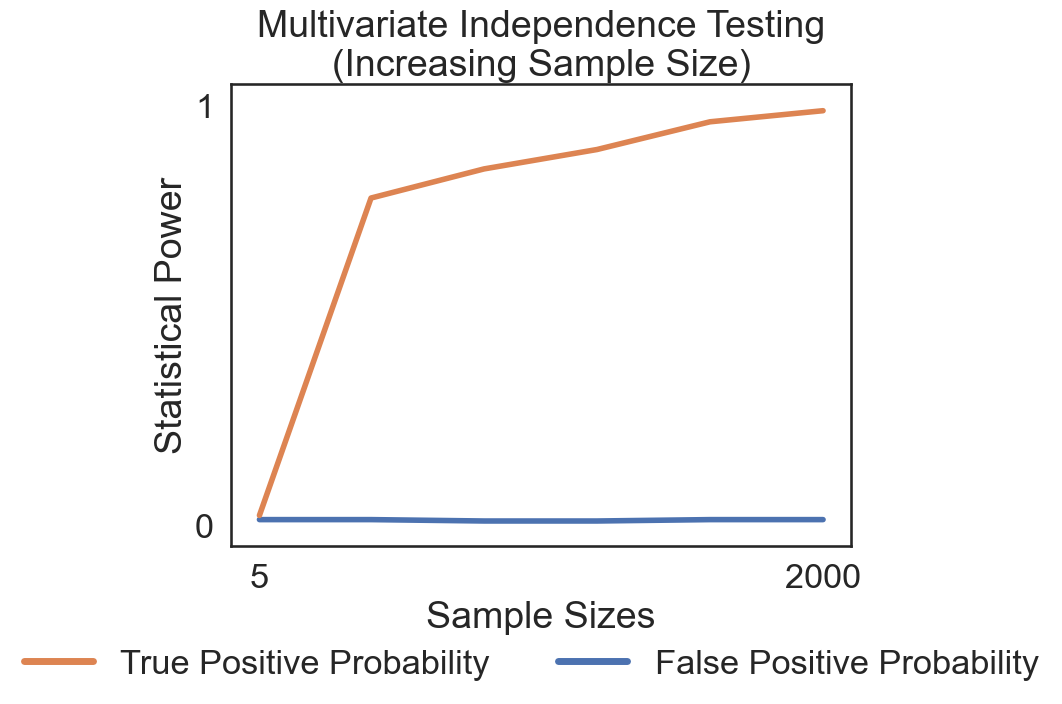

In [10]:
plot_power()